# Building a Parent Sample

The goal of this notebook is to build a parent sample of galaxies as part of a pilot analysis of the central galaxies in massive dark matter halos identified in Legacy Survey imaging.  

The sample will be required (1) to be in the redMaPPer cluster catalog; (2) have full-depth Legacy Survey *grzW1W2* imaging as part of the third data release (DR3); and (3) have *UPenn-PhotDec* photometry (maybe).

This code assumes that the large-scale matching of the redMaPPer and DR3 *Tractor* catalogs has already occurred, as documented in the [match-legacysurvey-redmapper.ipynb](http://localhost:8888/notebooks/match-legacysurvey-redmapper.ipynb) notebook.

TODO:
* Gather SDSS photometry for the parent redMaPPer sample.
* Match in this notebook to the UPenn catalog.
* ...

## Imports and paths

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import fitsio
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [3]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')

## Read the matched Legacy Survey and redMaPPer catalogs.

In [4]:
def convert_legacysurvey_datamodel(indata):
    """Convert from the (~obsolete) DR3 data model to the (latest) 
    DR4 data model.  
    
    This code was adapted from desitarget.io.convert_from_old_data_model
    and was originally written by Adam Myers (Wyoming).
    
    """
    from astropy.table import Table, Column
    
    nrows = len(indata)
    outdata = indata.copy()
    
    # Change the DECAM columns from the old (2-D array) to new (named 1-D array) data model.
    decamcols = ['FLUX', 'FLUX_IVAR', 'MW_TRANSMISSION', 'FRACFLUX', 'NOBS', 'GALDEPTH']
    decambands = 'UGRIZY'
    for colstring in decamcols:
        for bandnum in [1, 2, 4]:
            outdata.add_column(Column(name=colstring+'_'+decambands[bandnum], 
                                      data=indata['DECAM_'+colstring][:, bandnum]))
        outdata.remove_column('DECAM_'+colstring)
        
    # Treat DECAM_DEPTH separately as the syntax is slightly different.
    for bandnum in [1, 2, 4]:
        outdata.add_column(Column(name='PSFDEPTH_'+decambands[bandnum], 
                                  data=indata['DECAM_DEPTH'][:, bandnum]))
    outdata.remove_column('DECAM_DEPTH')

    # Change the WISE columns from the old (2-D array) to new (named 1-D array) data model.
    wisecols = ['FLUX', 'FLUX_IVAR', 'MW_TRANSMISSION']
    for colstring in wisecols:
        for bandnum in [1, 2, 3, 4]:
            outdata.add_column(Column(name=colstring+'_W'+str(bandnum),
                                      data=indata['WISE_'+colstring][:, bandnum-1]))
        outdata.remove_column('WISE_'+colstring)

    # Also include the RELEASE, which we'll always assume is DR3.
    outdata['RELEASE'] = 3000
    
    return outdata

In [5]:
def read_legacysurvey(dr='dr3', rmversion='v6.3.1'):
    """Read the matched Legacy Survey catalog converted to the >=DR4
    data model.
    
    Note that non-matching entries are populated with zeros / False.
    
    """
    lsfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                           'legacysurvey-{}-redmapper-{}.fits'.format(dr, rmversion) )
    ls = Table(fitsio.read(lsfile, ext=1, upper=True))
    
    print('Read {} objects from {}'.format(len(ls), lsfile))

    if dr == 'dr3':
        return convert_legacysurvey_datamodel(ls)
    else:
        return ls

In [6]:
def read_redmapper(rmversion='v6.3.1', index=None):
    """Read the parent redMaPPer catalog.
    
    """
    rmfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'dr8_run_redmapper_{}_lgt5_catalog.fit'.format(rmversion) )
    if index is not None:
        rm = Table(fitsio.read(rmfile, ext=1, upper=True, rows=index))
    else:
        rm = Table(fitsio.read(rmfile, ext=1, upper=True))
    print('Read {} objects from {}'.format(len(rm), rmfile))

    return rm

#### Require a match with redMaPPer and non-zero depth in all three bands.

In [7]:
dr, rmversion = 'dr3', 'v6.3.1'
lsall = read_legacysurvey(dr=dr, rmversion=rmversion)

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr3-redmapper-v6.3.1.fits


In [8]:
lsmatched = np.where( 
    (lsall['BRICK_PRIMARY']) * 
    (lsall['GALDEPTH_G'] > 0) * 
    (lsall['GALDEPTH_R'] > 0) * 
    (lsall['GALDEPTH_Z'] > 0) )[0]
print('Identified {} objects with grz photometry and a match to redMaPPer.'.format(len(lsmatched)))
ls = lsall[lsmatched]
ls[:3]

Identified 117216 objects with grz photometry and a match to redMaPPer.


BRICKID,BRICKNAME,OBJID,BRICK_PRIMARY,BLOB,NINBLOB,TYCHO2INBLOB,TYPE,RA,RA_IVAR,DEC,DEC_IVAR,BX,BY,BX0,BY0,LEFT_BLOB,OUT_OF_BOUNDS,DCHISQ [5],EBV,CPU_SOURCE,CPU_BLOB,BLOB_WIDTH,BLOB_HEIGHT,BLOB_NPIX,BLOB_NIMAGES,BLOB_TOTALPIX,"DECAM_APFLUX [6,8]","DECAM_APFLUX_RESID [6,8]","DECAM_APFLUX_IVAR [6,8]",DECAM_RCHI2 [6],DECAM_FRACMASKED [6],DECAM_FRACIN [6],DECAM_ANYMASK [6],DECAM_ALLMASK [6],DECAM_PSFSIZE [6],WISE_NOBS [4],WISE_FRACFLUX [4],WISE_RCHI2 [4],"WISE_LC_FLUX [2,5]","WISE_LC_FLUX_IVAR [2,5]","WISE_LC_NOBS [2,5]","WISE_LC_FRACFLUX [2,5]","WISE_LC_RCHI2 [2,5]","WISE_LC_MJD [2,5]",FRACDEV,FRACDEV_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,NOBS_G,NOBS_R,NOBS_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,RELEASE
int32,bytes8,int32,bool,int32,int16,bool,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,bool,bool,float32,float32,float32,float32,int16,int16,int32,int16,int32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
323959,1978m012,542,True,230,114,False,SIMP,197.8729809,2.65965e+13,-1.34103414787,2.55802e+13,1827.24,548.648,1828.0,548.0,False,False,1.44507e+06 .. 0.0,0.0271256,98.83,2659.62,659,531,111612,25,2118433,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,46 .. 12,1.30471 .. 2.67764,42.4932 .. 0.0669334,1514.04 .. 133.208,1.51918e-05 .. 0.0315186,1 .. 14,1.03157 .. 1.18566,0.0434259 .. 0.921605,55205.7 .. 56845.0,0.0,0.0,0.45,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.1986,63.4093,96.2782,89.2648,373.783,65.7552,0.922842,0.947347,0.970198,0.241098,0.218038,0.19708,1,14,5,172.531,768.147,108.549,221.125,1081.82,199.557,164.708,125.547,-102.58,235.646,0.962485,0.18554,0.000839168,1.77068e-05,0.995414,0.997181,0.999398,0.999773,3000
446678,1505p205,2526,True,1843,5,False,DEV,150.558906815,4.57863e+11,20.5379702433,5.47299e+11,1470.44,2321.25,1471.0,2322.0,False,False,42908.3 .. 82379.8,0.0262885,5.55,16.62,132,80,5687,3,16927,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,49 .. 12,0.0866151 .. 1.55385,3.68029 .. 0.088463,287.118 .. 0.0,0.0878988 .. 0.0,12 .. 0,0.0862845 .. 0.0,2.2379 .. 0.0,55326.4 .. 0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.61264,2245.84,-0.0414717,35997.3,0.181447,77284.4,20.446,95.1487,214.691,15.3069,3.90845,0.914887,0.925132,0.94893,0.971104,0.0108044,0.00973282,0.00904171,1,1,1,252.631,92.9049,15.1099,436.48,172.857,29.4644,281.093,187.426,-98.7617,297.542,0.377447,0.0873361,0.000344942,1.0752e-05,0.995555,0.997268,0.999417,0.99978,3000
340296,3221p015,6996,True,3590,35,False,DEV,322.109570091,3.64823e+12,1.60088810089,2.58004e+12,2011.43,3185.75,2011.0,3185.0,False,False,231436.0 .. 284399.0,0.04864,46.31,383.11,245,245,20828,9,185288,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,50 .. 10,0.173334 .. 4.70246,2.891 .. 0.0985604,270.362 .. 0.0,0.116819 .. 0.0,11 .. 0,0.163731 .. 0.0,2.06033 .. 0.0,55332.6 .. 0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.40274,16565.7,0.175521,299319.0,-0.0591032,158274.0,10.4836,62.4178,160.208,65.6692,37.0442,8.87

In [9]:
rmall = read_redmapper(rmversion=rmversion)

Read 396047 objects from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit


In [10]:
rm = rmall[lsmatched]
rm[:3]

MEM_MATCH_ID,RA,DEC,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
3,197.872957171,-1.34111627953,20.4303 .. 15.0278,0.495924 .. 0.0141083,15.3854,0.00549334,0.193564,0.00764036,32.7315,-1.0,-1.0,0.165282,0.185414,164.712,4.24162,157.558,3.99728,1.10496,1.00655,0.00508906,1.83547 .. 0.321014,0.0797838 .. 0.00102912,0.0790554 .. 0.0,34.0984,0.182398,0.00393653,1,0.0221436,23340301600130074,372.586,2.67244,375.259,0.159875 .. 0.204921,8.13114e-06 .. 1.31497e-05,1,1.65743,197.876240818,-1.34142305978,1.46013,2.03778,-741.054,128.44,24408.3,164.286,0.620295,5,3,197.872957171 .. 197.886363462,-1.34111627953 .. -1.32545764765,9222531 .. 9222794,164.712 .. 160.685,0.184493 .. 0.0,1.0 .. 1.0,0.660098 .. 0.000373478,0.653537 .. 0.000369766,0.000265913 .. 0.0163708,-18.7437,0.339636 .. 0.983256,0.98502 .. 0.0358702,8.11466,118.677,0.184493,0.00164668,85.9083,20.9194,21.2911
9,150.558906081,20.5379493669,21.5711 .. 16.8248,0.401919 .. 0.0208302,17.2187,0.0092044,0.306569,0.0114625,1.40643,0.319619,0.320468,0.295951,0.317106,151.364,5.76091,98.1242,4.6257,1.08644,0.997079,0.0,1.74573 .. 0.370654,0.417731 .. 0.00332962,0.407602 .. 0.0,0.998594,0.323677,0.0123536,3,0.0327382,51380301200690289,307.298,-0.798348,306.5,0.247393 .. 0.399961,8.58922e-09 .. 4.57415e-06,1,1.62966,150.611818763,20.5171651005,1.12414,9.12676,-79.2376,253.532,-3818.91,154.138,9.91694,5,2,150.558906081 .. 150.543315432,20.5379493669 .. 20.5236319612,39138941 .. 39138936,151.364 .. 140.136,0.310309 .. 0.0,1.0 .. 1.0,0.92111 .. 1.33771e-05,0.145202 .. 2.10875e-06,0.000286364 .. 0.0131093,-0.300226,0.0786037 .. 0.986877,0.147031 .. 2.50337e-06,4.79448,102.786,0.310309,0.00394149,127.225,21.2412,21.2911
20,322.109584838,1.60087170515,24.0007 .. 17.4126,2.1058 .. 0.02644,17.7546,0.0108127,0.395811,0.00717466,6.47623,-1.0,0.385041,0.374744,0.377297,189.288,7.49412,116.384,5.70357,1.13612,1.04372,0.0,1.75251 .. 0.388178,0.599929 .. 0.00717287,0.573663 .. 0.0,7.5852,0.387275,0.012855,2,0.0426325,77170301300760264,266.906,2.69635,269.602,0.319587 .. 0.454963,0.000158095 .. 3.96656e-06,1,1.70418,322.096474807,1.59247902161,1.11919,6.26228,-430.226,1021.0,10222.0,192.39,7.08487,5,2,322.109584838 .. 322.117679051,1.60087170515 .. 1.58487983563,48959462 .. 48959542,189.288 .. 186.725,0.374016 .. 0.0,1.0 .. 1.0,0.835161 .. 0.0003079,0.275138 .. 0.000101435,0.01381 .. 0.00397382,-0.761565,0.151029 .. 0.995718,0.290937 .. 0.000151247,4.62151,135.385,0.374016,0.00381926,138.411,21.2637,21.2911


## Build a couple plots to assess how to further cut the sample.

In particular, eventually we'll want to enforce "full-depth" *grz* imaging, but since DR3 is an incremental data release we'll just require the imaging for each source to be deeper than the median.

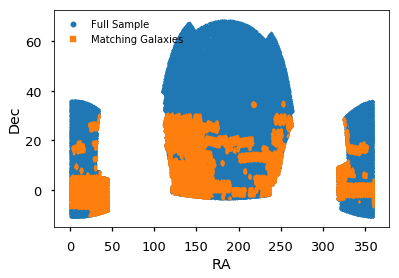

In [11]:
fig, ax = plt.subplots()
ax.scatter(rmall['RA'], rmall['DEC'], s=1, 
           label='Full Sample')
ax.scatter(rm['RA'], rm['DEC'], s=1, marker='s', label='Matching Galaxies')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10)
for ll in lgnd.legendHandles:
    ll._sizes = [30]

In [12]:
band = ['G', 'R', 'Z']
targdepth = [24.7, 23.9, 23.0] # target 5-sigma depth
meddepth = np.zeros((3))

g: median depth = 23.944, target depth = 24.700
r: median depth = 23.581, target depth = 23.900
z: median depth = 22.692, target depth = 23.000


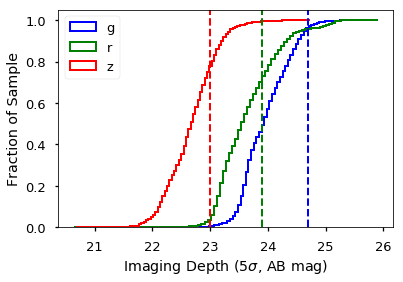

In [13]:
color = ('blue', 'green', 'red')
fig, ax = plt.subplots()
for ii, (tt, bb, col) in enumerate( zip( targdepth, band, color ) ):
    depth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(ls['GALDEPTH_{}'.format(bb)]) )
    meddepth[ii] = np.percentile(depth, [50])
    nn, bins, patches = ax.hist(depth, bins=100, histtype='step', cumulative=True,
                                label=bb.lower(), normed=True, color=col, lw=2)
    patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
    print('{}: median depth = {:.3f}, target depth = {:.3f}'.format(bb.lower(), meddepth[ii], tt))
    ax.axvline(x=tt, ls='--', color=col, lw=2, alpha=1.0)
    #ax.axvline(x=meddepth[ii], ls='-', color=col, lw=1, alpha=0.9)
ax.legend(loc='upper left')
ax.set_xlabel('Imaging Depth (5$\sigma$, AB mag)')
ax.set_ylabel('Fraction of Sample')

In [14]:
depthcut = np.ones(len(ls)).astype(bool)
for ii, bb in enumerate(['G', 'R', 'Z']):
    depth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(ls['GALDEPTH_{}'.format(bb)]) )
    depthcut *= depth > meddepth[ii]
print('{} objects pass the median depth cuts in all three bands.'.format(np.sum(depthcut)))

35242 objects pass the median depth cuts in all three bands.


In [15]:
rmdeep = rm[depthcut]
lsdeep = ls[depthcut]

## Write out the final sample.

In [16]:
rmoutfile = os.path.join(legacyhalos_dir, 'parent-redmapper-{}.fits'.format(rmversion))
print('Writing {}'.format(rmoutfile))
rmdeep.write(rmoutfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/parent-redmapper-v6.3.1.fits


In [17]:
lsoutfile = os.path.join(legacyhalos_dir, 'parent-legacysurvey-{}.fits'.format(dr))
print('Writing {}'.format(lsoutfile))
lsdeep.write(lsoutfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/parent-legacysurvey-dr3.fits


## Read the parent samples back in and generate a handful of QAplots.

In [18]:
rmparentfile = os.path.join(legacyhalos_dir, 'parent-redmapper-{}.fits'.format(rmversion))
print('Reading {}'.format(rmparentfile))
rmparent = fitsio.read(rmparentfile, ext=1)

Reading /Users/ioannis/research/projects/legacyhalos/parent-redmapper-v6.3.1.fits


In [19]:
lsparentfile = os.path.join(legacyhalos_dir, 'parent-legacysurvey-{}.fits'.format(dr))
print('Reading {}'.format(lsparentfile))
lsparent = fitsio.read(lsparentfile, ext=1)

Reading /Users/ioannis/research/projects/legacyhalos/parent-legacysurvey-dr3.fits


In [20]:
def _normhist(xx, ax, label=None, alpha=1.0, lw=2):
    _, _, _ = ax.hist(xx, weights=np.ones_like(xx) / float(len(xx)), 
                      bins=100, histtype='step', label=label,
                      lw=lw, alpha=alpha)

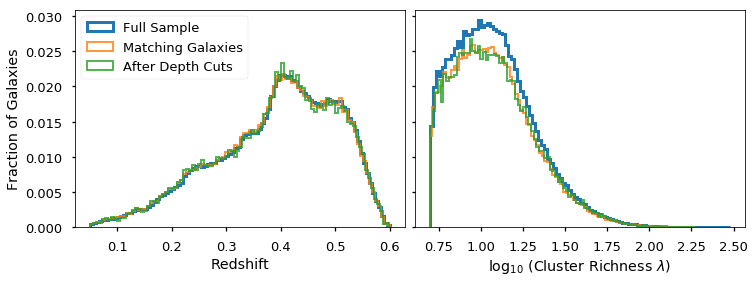

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

_normhist(rmall['Z'], ax1, label='Full Sample', lw=3)
_normhist(rm['Z'], ax1, label='Matching Galaxies', alpha=0.8)
_normhist(rmparent['Z'], ax1, label='After Depth Cuts', alpha=0.8)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left')

_normhist(np.log10(rmall['LAMBDA_CHISQ']), ax2, lw=3)
_normhist(np.log10(rm['LAMBDA_CHISQ']), ax2, alpha=0.8)
_normhist(np.log10(rmparent['LAMBDA_CHISQ']), ax2, alpha=0.8)
ax2.set_xlabel('$\log_{10}$ (Cluster Richness $\lambda$)')
#ax2.set_ylabel('Fraction of Galaxies')
fig.subplots_adjust(wspace=0.03)

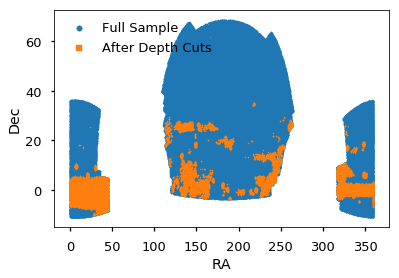

In [22]:
fig, ax = plt.subplots()
ax.scatter(rmall['RA'], rmall['DEC'], s=1, 
           label='Full Sample')
ax.scatter(rmparent['RA'], rmparent['DEC'], s=1, marker='s', label='After Depth Cuts')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
lgnd = ax.legend(loc='upper left', frameon=False)
for ll in lgnd.legendHandles:
    ll._sizes = [30]

#### Quick hack to see how many galaxies match the UPenn catalog

1419


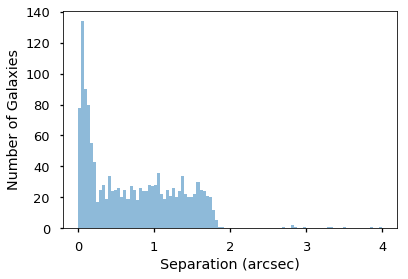

In [23]:
castfile = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec', 'basic-catalog', 'v2', 'UPenn_PhotDec_CAST.fits')
cast = Table(fitsio.read(castfile, ext=1, upper=True))
redcoord = SkyCoord(ra=rmparent['RA']*u.deg, dec=rmparent['DEC']*u.deg)
castcoord = SkyCoord(ra=cast['RA']*u.deg, dec=cast['DEC']*u.deg)
_, sep2d, _ = castcoord.match_to_catalog_sky(redcoord)
print(np.sum(sep2d.arcsec < 2.0))

fig, ax = plt.subplots()
_, _, _ = ax.hist(sep2d.arcsec, bins=100, range=(0, 4), alpha=0.5)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel('Number of Galaxies')